In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
!nvidia-smi


Mon Dec  8 00:24:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!pip -q install torchaudio torchvision transformers accelerate av decord
!apt-get -qq update
!apt-get -qq install -y ffmpeg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 128.3 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
!pip -q install soundfile
!pip -q install torchcodec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 81.6 MB/s eta 0:00:00


In [ ]:
import os
print(os.path.exists("/content/drive"))

False


In [ ]:
import json, os

ROOT = "/content/data_final/"  # change if needed
TEST_JSON  = os.path.join(ROOT, "test/clips.json")
TRAIN_JSON = os.path.join(ROOT, "train/clips.json")
VAL_JSON   = os.path.join(ROOT, "val/clips.json")

def load_manifest(p):
    with open(p, "r") as f:
        return json.load(f)

train_items = load_manifest(TRAIN_JSON)
val_items   = load_manifest(VAL_JSON)
test_items  = load_manifest(TEST_JSON)

print(len(train_items), len(val_items), len(test_items))
print(train_items[0].keys())


3111 664 777
dict_keys(['game_id', 'original_game_name', 'clip_name', 'half', 'start_ms', 'end_ms', 'highlight', 'video', 'audio', 'text', 'audio_img'])


In [ ]:
import soundfile as sf
import torch
import torchaudio

SR = 16000

def load_wav_sf(path, target_seconds=None):
    wav, sr = sf.read(path, always_2d=True)   # shape [T, C]
    wav = torch.from_numpy(wav).float().T     # -> [C, T]

    if sr != SR:
        wav = torchaudio.functional.resample(wav, sr, SR)

    wav = wav.mean(dim=0, keepdim=True)       # [1, T] mono

    if target_seconds is not None:
        target_len = int(SR * target_seconds)
        if wav.shape[1] < target_len:
            wav = torch.nn.functional.pad(wav, (0, target_len - wav.shape[1]))
        else:
            wav = wav[:, :target_len]

    return wav

N_MELS = 128

mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SR, n_mels=N_MELS, n_fft=1024, hop_length=320, win_length=1024
)
amp_to_db = torchaudio.transforms.AmplitudeToDB()

def load_audio_logmel(path, target_seconds=None):
    wav = load_wav_sf(path, target_seconds=target_seconds)  # [1, T]
    m = mel(wav)            # [1, n_mels, time]
    m = amp_to_db(m)        # log-mel
    return m.contiguous()


In [ ]:
import numpy as np
from decord import VideoReader, cpu
import torchvision.transforms as T

T_FRAMES = 16
IMG_SIZE = 224

vid_tf = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),  # [0,1]
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

def load_video_frames(path, num_frames=T_FRAMES):
    vr = VideoReader(path, ctx=cpu(0))
    n = len(vr)
    idx = np.linspace(0, n-1, num_frames).astype(np.int64)
    frames = vr.get_batch(idx).asnumpy()  # [T, H, W, C] uint8
    frames = torch.stack([vid_tf(f) for f in frames], dim=0)  # [T, 3, H, W]
    return frames


In [ ]:
from transformers import AutoTokenizer
TOKENIZER_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME)

MAX_TOKENS = 128

def load_text_tokens(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        txt = f.read().strip()
    if len(txt) == 0:
        txt = "[NO_TEXT]"
    tok = tokenizer(
        txt, truncation=True, padding="max_length", max_length=MAX_TOKENS, return_tensors="pt"
    )
    return {k: v.squeeze(0) for k,v in tok.items()}  # dict of [MAX_TOKENS]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def fix_items(items):
    for it in items:
        for k in ["audio","video","text","audio_img"]:
            if k in it and isinstance(it[k], str):
                it[k] = it[k].replace("data/data/", "")
    return items

train_items = fix_items(train_items)
val_items   = fix_items(val_items)
test_items  = fix_items(test_items)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class SoccerClips(Dataset):
    def __init__(self, items, root_prefix=None, audio_seconds=None):
        self.items = items
        self.root_prefix = root_prefix
        self.audio_seconds = audio_seconds

    def _fix(self, p):
        if self.root_prefix and not p.startswith("/"):
            return os.path.join(self.root_prefix, p)
        return p

    def __len__(self): return len(self.items)

    def __getitem__(self, i):
        it = self.items[i]
        y = torch.tensor(it["highlight"], dtype=torch.float32)

        audio = load_audio_logmel(self._fix(it["audio"]), target_seconds=self.audio_seconds)
        video = load_video_frames(self._fix(it["video"]), num_frames=T_FRAMES)
        text  = load_text_tokens(self._fix(it["text"]))

        return audio, video, text, y

train_ds = SoccerClips(train_items, root_prefix=ROOT, audio_seconds=8.0)
val_ds   = SoccerClips(val_items, root_prefix=ROOT, audio_seconds=8.0)
test_ds   = SoccerClips(test_items, root_prefix=ROOT, audio_seconds=8.0)


train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
test_dl   = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)


In [ ]:
audio, video, text, y = train_ds[0]
print("audio:", audio.shape)
print("video:", video.shape)
print("text keys:", text.keys(), {k: v.shape for k,v in text.items()})
print("label:", y)

batch = next(iter(train_dl))
audio_b, video_b, text_b, y_b = batch
print(audio_b.shape, video_b.shape, text_b["input_ids"].shape, y_b.shape)


audio: torch.Size([1, 128, 401])
video: torch.Size([16, 3, 224, 224])
text keys: dict_keys(['input_ids', 'attention_mask']) {'input_ids': torch.Size([128]), 'attention_mask': torch.Size([128])}
label: tensor(0.)
torch.Size([8, 1, 128, 401]) torch.Size([8, 16, 3, 224, 224]) torch.Size([8, 128]) torch.Size([8])


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as tvm
from transformers import AutoModel

# -------------------------
# Audio
# -------------------------
class AudioCNN(nn.Module):
    """
    Input:  [B, 1, 128, T]  (log-mel)
    Output: [B, d]
    """
    def __init__(self, d=256, drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.SiLU(),
            nn.MaxPool2d(2), nn.Dropout2d(drop),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.SiLU(),
            nn.MaxPool2d(2), nn.Dropout2d(drop),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.SiLU(),
            nn.MaxPool2d(2), nn.Dropout2d(drop),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.SiLU(),
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.proj = nn.Sequential(
            nn.Linear(256, d),
            nn.LayerNorm(d),
        )

    def forward(self, x):
        x = self.net(x)
        x = self.pool(x).flatten(1)  # [B, 256]
        return self.proj(x)          # [B, d]


# -------------------------
# Video (ResNet18 per-frame + temporal attention pooling)
# -------------------------
class VideoFrameEncoder(nn.Module):
    """
    Input:  [B, T, 3, 224, 224]
    Output: [B, d]
    """
    def __init__(self, d=256, pretrained=True, train_backbone=False, attn=True):
        super().__init__()
        weights = tvm.ResNet18_Weights.DEFAULT if pretrained else None
        resnet = tvm.resnet18(weights=weights)

        # ResNet without final FC -> [B*T, 512, 1, 1]
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        for p in self.backbone.parameters():
            p.requires_grad = train_backbone

        self.proj = nn.Linear(512, d)

        self.use_attn = attn
        if attn:
            self.attn = nn.Sequential(
                nn.Linear(d, d // 2),
                nn.Tanh(),
                nn.Linear(d // 2, 1)
            )

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        f = self.backbone(x).flatten(1)      # [B*T, 512]
        f = self.proj(f).view(B, T, -1)      # [B, T, d]

        if not self.use_attn:
            return f.mean(dim=1)             # [B, d]

        scores = self.attn(f).squeeze(-1)    # [B, T]
        w = torch.softmax(scores, dim=1).unsqueeze(-1)  # [B, T, 1]
        return (f * w).sum(dim=1)            # [B, d]


# -------------------------
# Text (HF transformer + masked mean pool)
# -------------------------
class TextEncoder(nn.Module):
    """
    Input: dict(input_ids=[B,L], attention_mask=[B,L])
    Output: [B, d]
    """
    def __init__(self, model_name="distilbert-base-uncased", d=256, train_backbone=False):
        super().__init__()
        self.lm = AutoModel.from_pretrained(model_name)
        for p in self.lm.parameters():
            p.requires_grad = train_backbone
        hidden = self.lm.config.hidden_size
        self.proj = nn.Linear(hidden, d)

    def forward(self, text_batch):
        out = self.lm(**text_batch)  # last_hidden_state [B, L, H]
        h = out.last_hidden_state
        mask = text_batch["attention_mask"].unsqueeze(-1).float()  # [B, L, 1]
        pooled = (h * mask).sum(dim=1) / mask.sum(dim=1).clamp_min(1.0)  # [B, H]
        return self.proj(pooled)  # [B, d]


class MultimodalEarlyFusionModel(nn.Module):
    """
    Feature-level early fusion: build embeddings per modality -> fuse -> classify.
    """
    def __init__(
        self,
        d=256,
        text_model_name="distilbert-base-uncased",
        dropout=0.2,
        pretrained_video=True,
        freeze_video=True,
        freeze_text=True,
        audio_drop=0.1,
        video_attn=True,
    ):
        super().__init__()
        self.audio_enc = AudioCNN(d=d, drop=audio_drop)
        self.video_enc = VideoFrameEncoder(
            d=d,
            pretrained=pretrained_video,
            train_backbone=not freeze_video,
            attn=video_attn
        )
        self.text_enc  = TextEncoder(
            model_name=text_model_name,
            d=d,
            train_backbone=not freeze_text
        )

        # learn per-sample modality weights

        self.fuse_norm = nn.LayerNorm(3*d)
        self.fuse_drop = nn.Dropout(dropout)

        self.head = nn.Sequential(
            nn.Linear(3*d, 2*d),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(2*d, d//2),
            nn.GELU(),
            nn.Linear(d//2, 1),
        )

    def forward(self, audio, video, text):
        a = self.audio_enc(audio)  # [B,d]
        v = self.video_enc(video)  # [B,d]
        t = self.text_enc(text)    # [B,d]

        z = torch.cat([a, v, t], dim=1)  # [B,3d]
        z = self.fuse_drop(self.fuse_norm(z))
        return self.head(z).squeeze(-1)  # [B]


In [ ]:
def freeze_module(m: nn.Module):
    for p in m.parameters():
        p.requires_grad = False

def unfreeze_resnet_layer4(video_enc: VideoFrameEncoder):
    # video_enc.backbone is resnet without fc; names include 'layer4'
    for name, p in video_enc.backbone.named_parameters():
        if "layer4" in name:
            p.requires_grad = True

def unfreeze_last_distilbert_layers(text_enc: TextEncoder, n_last=1):
    # DistilBERT: text_enc.lm.transformer.layer
    layers = getattr(getattr(text_enc.lm, "transformer", None), "layer", None)
    if layers is None:
        return  # not distilbert; skip

    # freeze all
    for p in text_enc.lm.parameters():
        p.requires_grad = False

    # unfreeze last n blocks
    for layer in layers[-n_last:]:
        for p in layer.parameters():
            p.requires_grad = True

    # keep projection trainable
    for p in text_enc.proj.parameters():
        p.requires_grad = True


In [ ]:
!pip -q install tqdm scikit-learn

import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ---- build model ----
model = MultimodalEarlyFusionModel(
    d=256,
    text_model_name="distilbert-base-uncased",
    dropout=0.2,
    pretrained_video=True,
    freeze_video=True,   # start frozen
    freeze_text=True,    # start frozen
    audio_drop=0.1,
    video_attn=True,
).to(device)

# ---- OPTIONAL: partial fine-tuning (recommended) ----
# If you want to fine-tune a little, do this:
# 1) freeze all pretrained backbones
freeze_module(model.video_enc.backbone)
freeze_module(model.text_enc.lm)
# 2) unfreeze only top layers
unfreeze_resnet_layer4(model.video_enc)
unfreeze_last_distilbert_layers(model.text_enc, n_last=1)

# ---- class imbalance ----
pos = sum(int(it["highlight"] == 1) for it in train_items)
neg = sum(int(it["highlight"] == 0) for it in train_items)
pos_weight = torch.tensor([neg / max(pos, 1)], device=device)
print(f"train pos={pos} neg={neg} pos_weight={pos_weight.item():.3f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# ---- optimizer with safe param groups ----
base_lr = 3e-4
video_lr = 3e-5
text_lr  = 2e-5

param_groups = [
    {"params": model.audio_enc.parameters(), "lr": base_lr},
    {"params": model.fuse_norm.parameters(), "lr": base_lr},
    {"params": model.head.parameters(),      "lr": base_lr},

    {"params": model.video_enc.proj.parameters(), "lr": base_lr},
    {"params": model.text_enc.proj.parameters(),  "lr": base_lr},
]
if hasattr(model.video_enc, "attn"):
    param_groups.append({"params": model.video_enc.attn.parameters(), "lr": base_lr})

video_trainables = [p for p in model.video_enc.backbone.parameters() if p.requires_grad]
if len(video_trainables) > 0:
    param_groups.append({"params": video_trainables, "lr": video_lr})

text_trainables = [p for p in model.text_enc.lm.parameters() if p.requires_grad]
if len(text_trainables) > 0:
    param_groups.append({"params": text_trainables, "lr": text_lr})

optimizer = torch.optim.AdamW(param_groups, weight_decay=1e-4)

EPOCHS = 8
# keep LR from going to literal 0
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# ---- batch -> device (non_blocking helps with pin_memory) ----
def to_device(batch):
    audio, video, text, y = batch
    audio = audio.to(device, non_blocking=True)
    video = video.to(device, non_blocking=True)
    text  = {k: v.to(device, non_blocking=True) for k, v in text.items()}
    y     = y.to(device, non_blocking=True)
    return audio, video, text, y

# ---- eval with metrics + best threshold on that split ----
@torch.no_grad()
def evaluate_full(model, dl, desc="val"):
    model.eval()
    total_loss, total = 0.0, 0
    all_probs, all_y = [], []

    pbar = tqdm(dl, desc=desc, leave=False)
    for batch in pbar:
        audio, video, text, y = to_device(batch)
        logits = model(audio, video, text)
        loss = criterion(logits, y)

        bs = y.size(0)
        total_loss += loss.item() * bs
        total += bs

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_probs.append(probs)
        all_y.append(y.detach().cpu().numpy())

        pbar.set_postfix(loss=total_loss/total)

    probs = np.concatenate(all_probs).astype(np.float64)
    ytrue = np.concatenate(all_y).astype(int)

    roc_auc = roc_auc_score(ytrue, probs) if len(np.unique(ytrue)) > 1 else float("nan")
    pr_auc  = average_precision_score(ytrue, probs) if len(np.unique(ytrue)) > 1 else float("nan")

    thresholds = np.linspace(0.05, 0.95, 19)
    best = {"thr": 0.5, "f1": -1, "precision": 0.0, "recall": 0.0, "acc": 0.0}
    for thr in thresholds:
        yhat = (probs >= thr).astype(int)
        f1 = f1_score(ytrue, yhat, zero_division=0)
        if f1 > best["f1"]:
            best = {
                "thr": float(thr),
                "f1": float(f1),
                "precision": float(precision_score(ytrue, yhat, zero_division=0)),
                "recall": float(recall_score(ytrue, yhat, zero_division=0)),
                "acc": float(accuracy_score(ytrue, yhat)),
            }

    yhat05 = (probs >= 0.5).astype(int)
    m05 = {
        "acc_05": float(accuracy_score(ytrue, yhat05)),
        "precision_05": float(precision_score(ytrue, yhat05, zero_division=0)),
        "recall_05": float(recall_score(ytrue, yhat05, zero_division=0)),
        "f1_05": float(f1_score(ytrue, yhat05, zero_division=0)),
    }

    return {
        "loss": total_loss / total,
        "roc_auc": float(roc_auc),
        "pr_auc": float(pr_auc),
        "best_thr": best["thr"],
        "best_acc": best["acc"],
        "best_precision": best["precision"],
        "best_recall": best["recall"],
        "best_f1": best["f1"],
        **m05
    }

# ---- training epoch ----
def train_one_epoch(model, dl, desc="train", grad_clip=1.0):
    model.train()
    total_loss, total = 0.0, 0
    pbar = tqdm(dl, desc=desc, leave=False)

    for batch in pbar:
        audio, video, text, y = to_device(batch)

        optimizer.zero_grad(set_to_none=True)
        logits = model(audio, video, text)
        loss = criterion(logits, y)
        loss.backward()

        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        total += bs

        pbar.set_postfix(train_loss=total_loss/total, lr=optimizer.param_groups[0]["lr"])

    return total_loss / total



device: cuda
train pos=610 neg=2501 pos_weight=4.100


In [ ]:
history = []
best_pr = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_dl, desc=f"train {epoch}/{EPOCHS}")
    scheduler.step()
    lr = optimizer.param_groups[0]["lr"]

    val_m = evaluate_full(model, val_dl, desc=f"val {epoch}/{EPOCHS}")

    history.append({
        "epoch": epoch,
        "lr": float(lr),
        "train_loss": float(train_loss),
        "val_loss": float(val_m["loss"]),
        "val_pr_auc": float(val_m["pr_auc"]),
        "val_roc_auc": float(val_m["roc_auc"]),
        "val_best_f1": float(val_m["best_f1"]),
        "val_best_thr": float(val_m["best_thr"]),
        "val_f1_05": float(val_m["f1_05"]),
    })

    if val_m["pr_auc"] > best_pr:
        best_pr = val_m["pr_auc"]
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | lr {lr:.2e} | train_loss {train_loss:.4f} | val_loss {val_m['loss']:.4f}\n"
        f"  AUC: ROC {val_m['roc_auc']:.3f} | PR {val_m['pr_auc']:.3f}\n"
        f"  Best-F1: {val_m['best_f1']:.3f} @ thr {val_m['best_thr']:.2f} "
        f"(P {val_m['best_precision']:.3f}, R {val_m['best_recall']:.3f}, Acc {val_m['best_acc']:.3f})\n"
        f"  @0.50: F1 {val_m['f1_05']:.3f} (P {val_m['precision_05']:.3f}, R {val_m['recall_05']:.3f}, Acc {val_m['acc_05']:.3f})"
    )

# restore best-by-PR model
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)
print("Best val PR-AUC:", best_pr)


train 1/8:   0%|          | 0/389 [00:00<?, ?it/s]

val 1/8:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 01/8 | lr 2.89e-04 | train_loss 1.0126 | val_loss 1.0293
  AUC: ROC 0.910 | PR 0.708
  Best-F1: 0.705 @ thr 0.20 (P 0.647, R 0.775, Acc 0.861)
  @0.50: F1 0.624 (P 0.722, R 0.549, Acc 0.858)


train 2/8:   0%|          | 0/389 [00:00<?, ?it/s]

val 2/8:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 02/8 | lr 2.56e-04 | train_loss 0.8516 | val_loss 0.7744
  AUC: ROC 0.897 | PR 0.679
  Best-F1: 0.679 @ thr 0.25 (P 0.556, R 0.873, Acc 0.824)
  @0.50: F1 0.654 (P 0.587, R 0.739, Acc 0.833)


train 3/8:   0%|          | 0/389 [00:00<?, ?it/s]

val 3/8:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 03/8 | lr 2.08e-04 | train_loss 0.7590 | val_loss 0.6486
  AUC: ROC 0.906 | PR 0.709
  Best-F1: 0.688 @ thr 0.80 (P 0.628, R 0.761, Acc 0.852)
  @0.50: F1 0.678 (P 0.554, R 0.873, Acc 0.822)


train 4/8:   0%|          | 0/389 [00:00<?, ?it/s]

val 4/8:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 04/8 | lr 1.50e-04 | train_loss 0.7612 | val_loss 0.8413
  AUC: ROC 0.896 | PR 0.694
  Best-F1: 0.677 @ thr 0.15 (P 0.545, R 0.894, Acc 0.818)
  @0.50: F1 0.656 (P 0.608, R 0.711, Acc 0.840)


train 5/8:   0%|          | 0/389 [00:00<?, ?it/s]

val 5/8:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 05/8 | lr 9.33e-05 | train_loss 0.6788 | val_loss 0.6863
  AUC: ROC 0.913 | PR 0.716
  Best-F1: 0.723 @ thr 0.50 (P 0.653, R 0.810, Acc 0.867)
  @0.50: F1 0.723 (P 0.653, R 0.810, Acc 0.867)


train 6/8:   0%|          | 0/389 [00:00<?, ?it/s]

val 6/8:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 06/8 | lr 4.48e-05 | train_loss 0.6236 | val_loss 1.4464
  AUC: ROC 0.889 | PR 0.676
  Best-F1: 0.673 @ thr 0.10 (P 0.618, R 0.739, Acc 0.846)
  @0.50: F1 0.588 (P 0.642, R 0.542, Acc 0.837)


train 7/8:   0%|          | 0/389 [00:00<?, ?it/s]

val 7/8:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 07/8 | lr 1.24e-05 | train_loss 0.5412 | val_loss 1.1663
  AUC: ROC 0.897 | PR 0.691
  Best-F1: 0.710 @ thr 0.20 (P 0.655, R 0.775, Acc 0.864)
  @0.50: F1 0.634 (P 0.634, R 0.634, Acc 0.843)


train 8/8:   0%|          | 0/389 [00:00<?, ?it/s]

val 8/8:   0%|          | 0/83 [00:00<?, ?it/s]

Epoch 08/8 | lr 1.00e-06 | train_loss 0.5843 | val_loss 1.4447
  AUC: ROC 0.890 | PR 0.680
  Best-F1: 0.693 @ thr 0.10 (P 0.646, R 0.746, Acc 0.858)
  @0.50: F1 0.605 (P 0.664, R 0.556, Acc 0.845)
Best val PR-AUC: 0.7161205156372435


In [ ]:
@torch.no_grad()
def evaluate_fixed_threshold(model, dl, thr=0.5, desc="test"):
    model.eval()
    all_probs, all_y = [], []

    pbar = tqdm(dl, desc=desc, leave=False)
    for batch in pbar:
        audio, video, text, y = to_device(batch)
        logits = model(audio, video, text)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_probs.append(probs)
        all_y.append(y.detach().cpu().numpy())

    probs = np.concatenate(all_probs).astype(np.float64)
    ytrue = np.concatenate(all_y).astype(int)
    yhat  = (probs >= thr).astype(int)

    return {
        "thr": thr,
        "acc": float(accuracy_score(ytrue, yhat)),
        "precision": float(precision_score(ytrue, yhat, zero_division=0)),
        "recall": float(recall_score(ytrue, yhat, zero_division=0)),
        "f1": float(f1_score(ytrue, yhat, zero_division=0)),
        "roc_auc": float(roc_auc_score(ytrue, probs)) if len(np.unique(ytrue))>1 else float("nan"),
        "pr_auc": float(average_precision_score(ytrue, probs)) if len(np.unique(ytrue))>1 else float("nan"),
    }

val_m = evaluate_full(model, val_dl, desc="val-final")
best_thr = val_m["best_thr"]

test_m = evaluate_fixed_threshold(model, test_dl, thr=best_thr, desc="test-final")
print(test_m)


val-final:   0%|          | 0/83 [00:00<?, ?it/s]

test-final:   0%|          | 0/98 [00:00<?, ?it/s]

{'thr': 0.49999999999999994, 'acc': 0.8404118404118404, 'precision': 0.5934065934065934, 'recall': 0.6835443037974683, 'f1': 0.6352941176470588, 'roc_auc': 0.8993067626428907, 'pr_auc': 0.6983977931519973}


In [ ]:
!ls "/content/data_final" | head


data_final.tar
test
train
val


In [ ]:
import torch, json, time, os

run_name = time.strftime("mm_early_fusion_%Y%m%d_%H%M%S")
save_dir = f"/content/drive/MyDrive/highlight_runs/{run_name}"
os.makedirs(save_dir, exist_ok=True)

ckpt_path = f"{save_dir}/model.pt"

torch.save({
    "model_state_dict": model.state_dict(),
    "config": {
        "d": 256,
        "text_model_name": "distilbert-base-uncased",
        "T_FRAMES": T_FRAMES,
        "audio_seconds": 8.0,
    },
    "threshold": best_thr,        # the val-picked threshold you used for test
    "val_metrics": val_m,         # dict
    "test_metrics": test_m,       # dict
}, ckpt_path)

print("Saved:", ckpt_path)

metrics_path = f"{save_dir}/metrics.json"
with open(metrics_path, "w") as f:
    json.dump({
        "threshold": best_thr,
        "val_metrics": val_m,
        "test_metrics": test_m,
    }, f, indent=2)

print("Saved:", metrics_path)

history_path = f"{save_dir}/history.json"
with open(history_path, "w") as f:
    json.dump(history, f, indent=2)
print("Saved:", history_path)




Saved: /content/drive/MyDrive/highlight_runs/mm_early_fusion_20251208_062203/model.pt
Saved: /content/drive/MyDrive/highlight_runs/mm_early_fusion_20251208_062203/metrics.json
Saved: /content/drive/MyDrive/highlight_runs/mm_early_fusion_20251208_062203/history.json


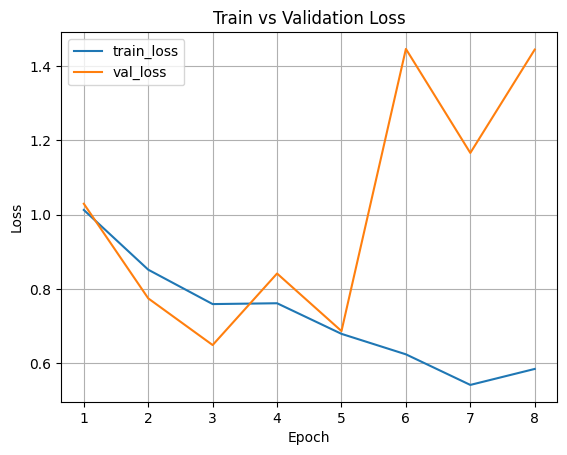

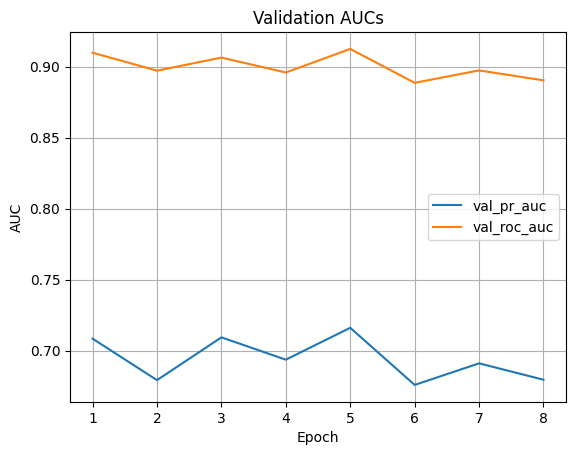

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# 1) paste your history list into this variable
history = [
  {"epoch": 1, "lr": 0.0002886199901104373, "train_loss": 1.0125618629308424, "val_loss": 1.0292985347290355,
   "val_pr_auc": 0.7084764228170151, "val_roc_auc": 0.9099077221952405, "val_best_f1": 0.7051282051282052,
   "val_best_thr": 0.2, "val_f1_05": 0.624},
  {"epoch": 2, "lr": 0.0002562124637873888, "train_loss": 0.8516448448322012, "val_loss": 0.7743957469082741,
   "val_pr_auc": 0.6792451155217276, "val_roc_auc": 0.8972397604014893, "val_best_f1": 0.6794520547945205,
   "val_best_thr": 0.25, "val_f1_05": 0.6542056074766355},
  {"epoch": 3, "lr": 0.00020771117313858086, "train_loss": 0.7589993457277271, "val_loss": 0.648628647427961,
   "val_pr_auc": 0.7093930361722777, "val_roc_auc": 0.90645404997032, "val_best_f1": 0.6878980891719745,
   "val_best_thr": 0.7999999999999999, "val_f1_05": 0.6775956284153005},
  {"epoch": 4, "lr": 0.00015049999999999994, "train_loss": 0.7612409250662856, "val_loss": 0.8413445226264646,
   "val_pr_auc": 0.6936658766053893, "val_roc_auc": 0.8959581242242729, "val_best_f1": 0.6773333333333333,
   "val_best_thr": 0.15, "val_f1_05": 0.6558441558441559},
  {"epoch": 5, "lr": 9.328882686141905e-05, "train_loss": 0.6787732172552622, "val_loss": 0.6863024372113756,
   "val_pr_auc": 0.7161205156372435, "val_roc_auc": 0.9125654308995736, "val_best_f1": 0.7232704402515723,
   "val_best_thr": 0.49999999999999994, "val_f1_05": 0.7232704402515723},
  {"epoch": 6, "lr": 4.4787536212611134e-05, "train_loss": 0.6236365114253976, "val_loss": 1.4464371761374444,
   "val_pr_auc": 0.6758824208240181, "val_roc_auc": 0.8886865252819599, "val_best_f1": 0.6730769230769231,
   "val_best_thr": 0.1, "val_f1_05": 0.5877862595419847},
  {"epoch": 7, "lr": 1.238000988956263e-05, "train_loss": 0.5412048420996642, "val_loss": 1.1662506129458008,
   "val_pr_auc": 0.6910799891385208, "val_roc_auc": 0.8974286331012897, "val_best_f1": 0.7096774193548387,
   "val_best_thr": 0.2, "val_f1_05": 0.6338028169014085},
  {"epoch": 8, "lr": 1e-06, "train_loss": 0.5842850796270029, "val_loss": 1.4447007085566959,
   "val_pr_auc": 0.6795487794421228, "val_roc_auc": 0.8904268523015488, "val_best_f1": 0.6928104575163399,
   "val_best_thr": 0.1, "val_f1_05": 0.6053639846743295},
]

df = pd.DataFrame(history).sort_values("epoch")

# 2) Train vs Val loss on the same plot
plt.figure()
plt.plot(df["epoch"], df["train_loss"], label="train_loss")
plt.plot(df["epoch"], df["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

# 3) Optional: PR-AUC & ROC-AUC plot
plt.figure()
plt.plot(df["epoch"], df["val_pr_auc"], label="val_pr_auc")
plt.plot(df["epoch"], df["val_roc_auc"], label="val_roc_auc")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Validation AUCs")
plt.grid(True)
plt.legend()
plt.show()
